<a href="https://colab.research.google.com/github/dlkt101101/STAT441-Project/blob/main/STAT441_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 441: Statistical Learning - Classification
## Classifying Astrophysical Images
Prepared by:\
Darren Alexander Lam Kin Teng\
Ojus Udagani\
Raghuv

In [2]:
# !pip install Pillow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
import keras
import os
from google.colab import drive

In [4]:
from keras.src.applications.vgg16 import preprocess_input
# importing keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, RandomFlip, RandomRotation, \
RandomZoom, RandomShear, Normalization, Dropout, Flatten, Lambda
from keras.activations import relu, sigmoid, softmax
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications import VGG16, VGG19, ResNet50
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

## Importing the dataset

In [5]:
path = '/content/drive/MyDrive'

In [6]:
training_path = path+'/astro_dataset_maxia/astro_dataset_maxia/training'
test_path = path+'/astro_dataset_maxia/astro_dataset_maxia/test'
validation_path = path+'/astro_dataset_maxia/astro_dataset_maxia/validation'

Creating training, validation and testing batches for images.

In [7]:
BATCH_SIZE =32
IMAGE_SIZE =(256, 256)
SEED = 123

From the TensorFlow documentation the supported image formats: `.jpeg`, `.jpg`, `.png`, `.bmp`, `.gif`. We must verify whether all images are in such format before loading in our batches.

In [8]:
training_batch = tf.keras.utils.image_dataset_from_directory(
    directory=training_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED)
class_names = training_batch.class_names
training_batch = training_batch.prefetch(tf.data.AUTOTUNE)

validation_batch = tf.keras.utils.image_dataset_from_directory(
    directory=validation_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED).prefetch(tf.data.AUTOTUNE)

test_batch = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED).prefetch(tf.data.AUTOTUNE)

Found 2303 files belonging to 12 classes.
Found 622 files belonging to 12 classes.
Found 345 files belonging to 12 classes.


Remove any problematic files from batches.

Visualizing the Images

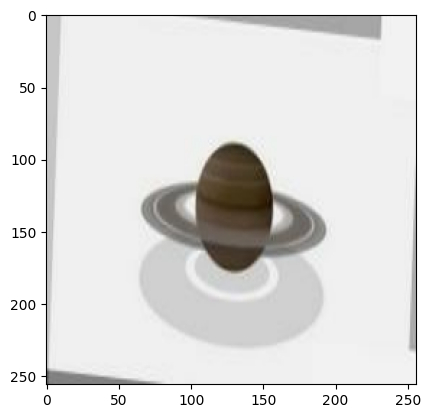

In [9]:
iterator = iter(training_batch)
img = next(iterator)
img = img[0][0].numpy().astype(np.int32)

# let's visualize an image
plt.imshow(img)

Implementing image preprocessing by:
1. Resizing the image (completed and resized to (256,256) )
2. Normalizing the pixel values
3. Data Augmentations\
  3.1. Normalization of pixel values\
  3.2. Random Rotations\
  3.3. Random Shear\
  3.4. Random Zoom\
  3.5. Random Flip

## Model Implementaion


### Neural Network Implementaion

We will implement multiple pre-trained Convolutional Neural Networks (CNN) and fine-tune them to our astrophysical dataset. Such models include:
* VGG16
* VGG19
* ResNet
#### VGG 16

In [10]:
mVGG16 = VGG16(include_top= False,
              input_shape=(256,256,3),
              weights='imagenet',
              name = "vgg16")

# we will avoid training on previous layers
for layer in mVGG16.layers:
  layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
mVGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
model = Sequential([
    Lambda(vgg16_preprocess_input),
    RandomRotation(0.5),
    RandomShear(x_factor=0.9, y_factor=0.9),
    RandomZoom(0.2),
    RandomFlip(mode="horizontal_and_vertical"),
    mVGG16,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer = Adam(learning_rate=0.001))


In [13]:
model.fit(x=training_batch, validation_data=validation_batch, epochs=5, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/5
 4/72 ━━━━━━━━━━━━━━━━━━━━ 18:33 16s/step - loss: 28.4463

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_2888]

In [14]:
import os
from PIL import Image

# List all your dataset paths
paths_to_check = [training_path, validation_path, test_path]

corrupt_files = []
valid_extensions = ('.jpg', '.jpeg', '.png')

print("Starting file integrity check...")

for data_path in paths_to_check:
    for root, _, files in os.walk(data_path):
        for file in files:
            # Skip non-image files immediately
            if not file.lower().endswith(valid_extensions):
                continue

            file_path = os.path.join(root, file)
            try:
                # Open the image file
                img = Image.open(file_path)
                # Attempt to load the image data (will raise an error if corrupt)
                img.verify()
            except Exception as e:
                # If an error occurs, it's corrupt/malformed
                print(f"🚨 Corrupt file detected: {file_path}. Error: {e}")
                corrupt_files.append(file_path)

if corrupt_files:
    print(f"\nTotal corrupt files found: {len(corrupt_files)}")
    print("Please delete or move these files and re-run your tf.keras.utils.image_dataset_from_directory calls.")
else:
    print("\n✅ File integrity check complete. No corrupt image files found.")

# Note: You may need to run `!pip install Pillow` first if it's not available.

Starting file integrity check...


KeyboardInterrupt: 